In [1]:
!nvidia-smi

Tue Sep 16 16:31:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:3B:00.0 Off |                  Off |
| 30%   45C    P8             29W /  300W |      31MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax
import numpy as np
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)  

from astropy.io import fits
import emcee
import yaml

from radjax import inference
from radjax import sensor
from radjax import utils
from radjax import chemistry as chem
from radjax.models import broken_power_law as disk_model
from radjax.models.broken_power_law import forward_model_with_rays
import matplotlib.pyplot as plt
from radjax.core import visualization
from radjax.core.alma_io import prepare_alma_cube, subsample_cube_uniform

In [3]:
rng_seed_synth = 1234  # for JAX noise
numpy_seed     = 2025  # for emcee RNG

data_path = '/scratch/ondemand28/len/data/radjax/flaherty/HD163296_CO_highres_cen.cm.fits'
params_path = '../data/HD163296/Flaherty/HD163296_CO_highres_cen.cm.params.yaml'

disk_params = disk_model.disk_from_yaml(params_path)
chem_params = chem.chemistry_from_yaml_path(params_path)
mol = chem.load_molecular_tables(chem_params)

obs_params = sensor.params_from_yaml(params_path)
sensor.print_params(obs_params)

# Load datacube and associated metadata from FITS
alma_cube = prepare_alma_cube(data_path, obs_params, to_jax=True)

num_freqs_resample = 60
alma_cube = subsample_cube_uniform(alma_cube, num_freqs_resample)

disk_model.print_params(disk_params)
chem.print_params(chem_params)


 Dataset name:            HD163296 - Flaherty CO(2-1)
 Mode:                    REAL (observed cube)
--------------------------------------------------
 Distance (pc):             122.00
 Field of view (arcsec):    11.000
 Velocity range (m/s):      2000.0 →  10000.0
 VLSR (m/s):               5760.00
--------------------------------------------------
 Number of rays:               100
 Inclination (deg):          47.50
 Phi (deg):                   0.00
 Position angle (deg):      312.00
 Slab thickness z_width (AU):   400.00
Disk parameters (parametric broken power law model):
  Midplane T_norm (K):          17.80
  Atmosphere T_norm (K):        87.00
  q (outer exponent):          -0.270
  q_in (inner exponent):       -0.570
  r_break (AU):                 70.00
  log(r_c [AU]):                 2.30
  gamma (Σ slope):              1.000

  Stellar mass (M_sun):         2.300
  Gas mass (M_sun):             0.090

  r_in (AU):                    11.00
  r_scale (AU):                1

In [4]:
temperature, v_phi, co_nd, base_disk = disk_model.co_disk_from_params(
    disk_params, chem_params
)

print("Disk fields summary (azimuthal/mirror symmetric fields):")
print(f"  Temperature:        {temperature.shape}, dtype={temperature.dtype}")
print(f"  CO Number Density:  {co_nd.shape}, dtype={co_nd.dtype}")
print(f"  Azimuthal Velocity: {v_phi.shape}, dtype={v_phi.dtype}")

Disk fields summary (azimuthal/mirror symmetric fields):
  Temperature:        (500, 500), dtype=float64
  CO Number Density:  (500, 500), dtype=float64
  Azimuthal Velocity: (500, 500), dtype=float64


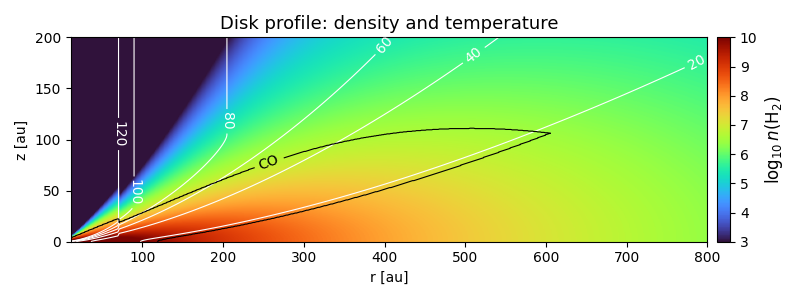

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,3))
visualization.plot_disk_profile_rz(
    ax, base_disk.r, base_disk.z, base_disk.h2_nd, temperature, co_nd
)
plt.tight_layout()

In [6]:
rays = sensor.rays_from_params(obs_params, alma_cube.x_sky, alma_cube.y_sky)

In [7]:
nd_ray, temperature_ray, velocity_ray = sensor.sample_symmetric_disk__along_rays(
    rays=rays,
    bbox=base_disk.bbox,
    co_nd=co_nd,
    temperature=temperature,
    v_phi=v_phi,
)

In [8]:
images = sensor.render_cube(
    rays, nd_ray, temperature_ray, velocity_ray,
    nu0=alma_cube.nu0,
    freqs=alma_cube.freqs,
    v_turb=disk_params.v_turb,
    mol=mol,
)

In [9]:
model_cube = sensor.fftconvolve_vmap(images, alma_cube.beam_kernel)

interactive(children=(IntSlider(value=29, description='frame', max=59), Output()), _dom_classes=('widget-inter…

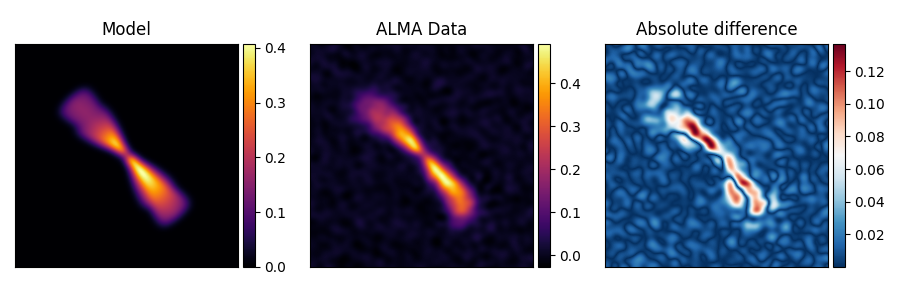

In [10]:
%matplotlib widget
visualization.slider_frame_comparison(
    model_cube, alma_cube.data,
    title1="Model",
    title2="ALMA Data"
)


In [11]:
class DiskParamsAdapter:
    def apply(self, disk_params, theta):
        return disk_params.replace(
            q = theta[0],
            log_r_c = theta[1],
            v_turb = theta[2],
            T_atm1 = theta[3],
            T_mid1 = theta[4],
            r_in = theta[5],
            r_break = theta[6],
            q_in = theta[7],
        )
    
# SamplerState (static context)
state = inference.SamplerState(
    obs_params=obs_params,   
    disk_params=disk_params,        
    chem_params=chem_params,
    base_disk=base_disk,
    rays=rays,               
    mol=mol,      
    beam=None,
    use_pressure_correction=True,
    sigma=0.0074, # RMS noise (in Jy/beam),
    adapter=DiskParamsAdapter()
)

In [12]:
def generate_p0(param_bounds, n_walkers, rng_seed):
    np.random.seed(rng_seed)
    ndim = len(param_bounds)
    p0 = np.empty((n_walkers, ndim), dtype=float)

    for i, (low, high) in enumerate(param_bounds):
        p0[:, i] = np.random.uniform(low, high, size=n_walkers)
    return p0

def log_prior(theta, param_bounds):
    for i, (low, high) in enumerate(param_bounds):
        if not (low <= theta[i] <= high):
            return -jnp.inf
    return 0.0

@jax.jit
def render_image_from_theta(theta_jnp: jnp.ndarray) -> jnp.ndarray:
    disk_state = state.adapter.apply(state.disk_params, theta_jnp)

    return forward_model_with_rays(
        disk_params=disk_state,
        chem_params=state.chem_params,
        mol=state.mol,
        rays=state.rays,
        freqs=alma_cube.freqs,
        beam_kernel=alma_cube.beam_kernel,
        output="image",
        use_pressure_correction=state.use_pressure_correction,
    )

def loglikelihood(theta_jnp: jnp.ndarray) -> float:
    cube_model = render_image_from_theta(theta_jnp)
    residual = (cube_model - alma_cube.data) / state.sigma
    return -0.5 * jnp.sum(residual * residual)

def log_prob(theta, param_bounds):
    log_prior_theta = log_prior(theta, param_bounds)
    if not jnp.isfinite(log_prior_theta):
        return -jnp.inf
    loglikelihood_theta = loglikelihood(jnp.array(theta))
    return log_prior_theta + loglikelihood_theta


In [ ]:
mcmc_backend_file = "tutorial06_artifacts/mcmc_hd163296.h5"
mcmc_num_walkers = 32
mcmc_num_steps  = 400
mcmc_num_warmup = 100
mcmc_discard_steps = 100
mcmc_p1_ball_size = 1e-2 # Relative spread of Gaussian ball around median after warmup

mcmc_param_bounds = [
    (-0.5, 0.0),          # q
    (1.75, 2.5),  # log_r_c
    (0.0, 1.0),          # v_turb
    (40.0, 150),       # T_atm1
    (5.0, 40.0),       # T_mid1
    (1.0, 20.0),         # r_in
    (15.0, 115.0),       # r_break
    (-1.0, 0.0),          # q_in
]

mcmc_param_names = [
    'q',
    'log_r_c',
    'v_turb',
    'T_atm1',
    'T_mid1',
    'r_in',
    'r_break',
    'q_in',
]

mcmc_num_dim = len(mcmc_param_bounds)

backend = emcee.backends.HDFBackend(mcmc_backend_file)
backend.reset(mcmc_num_walkers, mcmc_num_dim)

In [15]:
mcmc_p0 = generate_p0(
    param_bounds=mcmc_param_bounds,
    n_walkers=mcmc_num_walkers,
    rng_seed=numpy_seed
)

sampler = emcee.EnsembleSampler(
    mcmc_num_walkers,
    mcmc_num_dim,
    log_prob,
    args=(mcmc_param_bounds,),
    backend=backend,
)

warmup_sampler = sampler.run_mcmc(mcmc_p0, mcmc_num_warmup, progress=True)

print("Finished Warm up. Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

100%|██████████| 100/100 [10:40<00:00,  6.41s/it]

Finished Warm up. Mean acceptance fraction: 0.295625


In [16]:
warmup_flat_samples = sampler.get_chain(flat=True)
warmup_medians = np.median(warmup_flat_samples, axis=0)
p1 = np.random.normal(warmup_medians, mcmc_p1_ball_size * np.abs(warmup_medians), size=(mcmc_num_walkers, mcmc_num_dim))

print("Starting MCMC sampling from warmup median +/- small Gaussian ball")

print("Running MCMC:")
import time
start_time_mcmc = time.time()
sampler.run_mcmc(p1, mcmc_num_steps, progress=True)
end_time_mcmc = time.time()
mcmc_time = end_time_mcmc - start_time_mcmc
print(f"MCMC completed in {mcmc_time:.2f} seconds.")
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

Starting MCMC sampling from warmup median +/- small Gaussian ball
Running MCMC:


100%|██████████| 400/400 [44:45<00:00,  6.71s/it]

MCMC completed in 2692.09 seconds.
Mean acceptance fraction: 0.15725


In [26]:
chain = sampler.get_chain(flat=True)
logp  = sampler.get_log_prob(flat=True)

params_medians = np.median(chain, axis=0)

print(f"MCMC Medians:")
for param_name, param_val in zip(mcmc_param_names, params_medians):
    print(f"    {param_name}: {param_val:.3f}")

# posterior predictive at MAP
disk_MCMC = state.adapter.apply(state.disk_params, params_medians)
cube_MCMC = forward_model_with_rays(
    disk_params=disk_MCMC, 
    chem_params=state.chem_params,
    mol=state.mol,
    rays=state.rays,
    freqs=alma_cube.freqs,
    beam_kernel=alma_cube.beam_kernel,
    output="image",
    use_pressure_correction=state.use_pressure_correction)

rms = np.sqrt(np.mean((np.asarray(cube_MCMC) - alma_cube.data)**2))
print(f"Posterior predictive RMS (MAP): {rms:.4f}")


MCMC Medians:
    q: -0.209
    log_r_c: 2.247
    v_turb: 0.080
    T_atm1: 85.982
    T_mid1: 16.989
    r_in: 8.483
    r_break: 72.646
    q_in: -0.489
Posterior predictive RMS (MAP): 0.0183


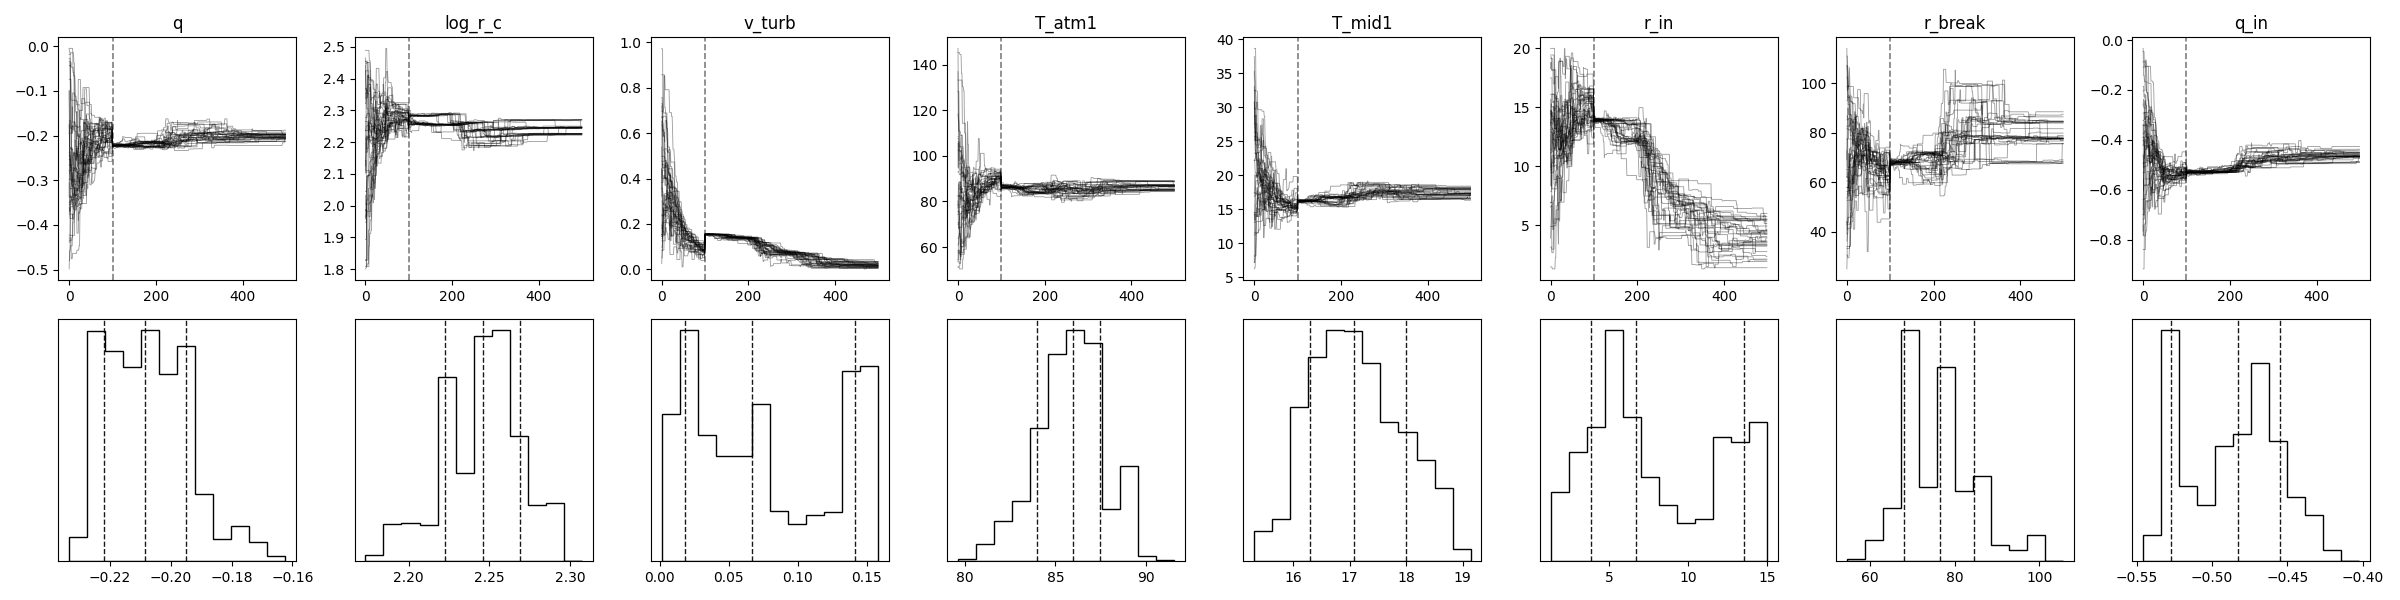

In [23]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=mcmc_discard_steps, thin=1, flat=True)

quantiles = [16, 50, 84]
n_params = len(mcmc_param_names)

fig, axes = plt.subplots(2, n_params, figsize=(3 * n_params, 6))
if n_params == 1:
    axes = axes.reshape(2, 1)  # one param case

for i, label in enumerate(mcmc_param_names):
    # Top: Walker plot
    ax_trace = axes[0, i]
    for walker in samples[:, :, i].T:
        ax_trace.plot(walker, alpha=0.4, lw=0.6, color='black')
    ax_trace.axvline(mcmc_discard_steps, color='k', ls='--', lw=1.2, alpha=0.5)  # vertical line
    ax_trace.set_title(label)

    # Bottom: Histogram
    ax_hist = axes[1, i]
    data_p = flat_samples[:, i]
    ax_hist.hist(
        data_p, bins=12, density=True, histtype='stepfilled',
        facecolor='white', lw=1, color='white', edgecolor='k'
    )

    q16, q50, q84 = np.percentile(data_p, quantiles)
    for q in (q16, q50, q84):
        ax_hist.axvline(q, color='k', ls='--', lw=1, alpha=0.9)
        
    ax_hist.set_yticks([])

plt.tight_layout()
plt.show()

interactive(children=(IntSlider(value=29, description='frame', max=59), Output()), _dom_classes=('widget-inter…

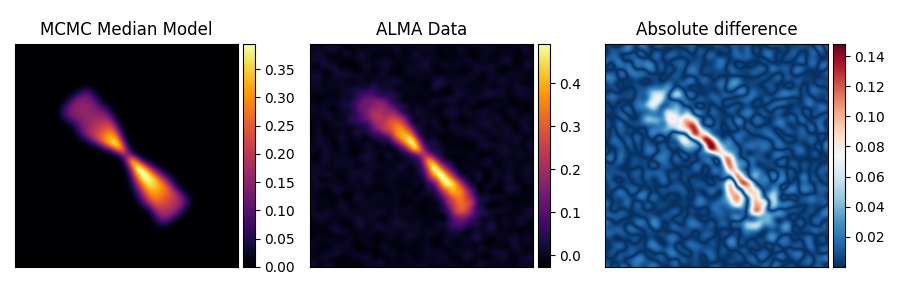

In [24]:
%matplotlib widget
visualization.slider_frame_comparison(
    cube_MCMC, alma_cube.data,
    title1="MCMC Median Model",
    title2="ALMA Data"
)

In [25]:
mcmc_params = {
    "method": "emcee",
    "mcmc_backend_file": mcmc_backend_file,
    "alma_fits_path": data_path,
    "params_yaml_path": params_path,
    "numpy_seed": numpy_seed,
    "mcmc_discard_steps": mcmc_discard_steps,
    "mcmc_num_warmup": mcmc_num_warmup,
    "mcmc_num_walkers": mcmc_num_walkers,
    "mcmc_num_steps": mcmc_num_steps,
    "mcmc_p1_ball_size": mcmc_p1_ball_size,
    "sampled_params": mcmc_param_names,
    "sigma": state.sigma,
    "use_pressure_correction": state.use_pressure_correction,
    "num_freqs": int(alma_cube.freqs.shape[0]),
    "npix": int(alma_cube.npix),
    "nu0": float(alma_cube.nu0),
    "bounds": {name: bound for name, bound in zip(mcmc_param_names, mcmc_param_bounds)},
    "freqs": alma_cube.freqs.tolist(),
}

results = {
    "mcmc_datetime": time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()),
    "mcmc_time_seconds": mcmc_time,
    "mcmc_acceptance_fraction_mean": float(np.mean(sampler.acceptance_fraction)),
    "mcmc_acceptance_fraction_std": float(np.std(sampler.acceptance_fraction)),
    "mcmc_medians": {name: float(val) for name, val in zip(mcmc_param_names, params_medians)},
    "mcmc_medians_rms": float(rms),
    "mcmc_quantiles": {name: {f"q{q}": float(val) for q, val in zip(quantiles, np.percentile(flat_samples[:, i], quantiles))} for i, name in enumerate(mcmc_param_names)},
    
}

output_yaml_path = "tutorial06_artifacts/params-and-mcmc-results.yaml"
disk_model.params_to_yaml_path(disk_MCMC, output_yaml_path)
chem.chemistry_to_yaml_path(chem_params, output_yaml_path)
inference.append_inference_to_yaml(output_yaml_path, mcmc_params, results)